## Compute monthly sea-ice concentration climatologies from EUMETSAT OSI SAF data

We compute monthly cliamtologies (1981-2010, 1991-2020) from EUMETSAT OSI SAF SIC CDR v3 data. This uses xarray.

**NB :** This software is for demonstration purpose only, it is not finalized for production.

In [35]:
import os
import xarray as xr

from datetime import date, datetime, timedelta, time
from dateutil import rrule, relativedelta

import cftime

import json
import uuid
from copy import copy
import numpy as np

Configuration of the run

In [8]:
area = 'nh'
outdir = '.'
indirs = None

# climo : years to include in the climatology run. **Both ends are included**.
climo = (1981, 1990)

In [9]:
# input monthly SIC files
fn_patt = 'ice_conc_{a:}_ease2-250_{c:}_{d:%Y%m}.nc'
fn_patt_src = {'cdr': 'cdr-v3p0', 'icdr': 'icdr-v3p0', 'icdrft': 'icdrft-v3p0'}

if indirs is None:
    inpdir_cdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/'
    inpdir_icdr = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/monthly/'
    # access through THREDDS/OpenDAP
    sources = {'cdr':inpdir_cdr,
              'icdr':inpdir_icdr,
              'icdrft':inpdir_icdr}
    jsond = json.dumps(sources, sort_keys=True, indent=4)
else:
    # load json file with path to input directories (if the daily SIC files are downloaded to a local disk)
    # an example json file (prepare_monthly_osisaf_sic_opendap.json) is provided to demonstrate the format
    #   expected for the json file (but the effect will be the same as setting indirs to None: read from
    #   THREDDS/opendap)
    with open(indirs, 'r') as f:
        sources = json.load(f)

In [10]:
def find_one_monthly_sic_file(dt, area):
    
    found_one_file = False
    for cdr in ('cdr', 'icdr', 'icdrft'):
        fn = fn_patt.format(a=area, d=dt, c=fn_patt_src[cdr])
        fn = os.path.join(sources[cdr],'{:%Y/}'.format(dt),fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            return fn, cdr
        except OSError:
            # no valid file at this url, check the next rule
            # print("Failed with pattern {}".format(fn))
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        print("WARNING: could not find OSI SAF SIC v3 file for {} {}".format(area, dt))
        return None, None

def find_climo_monthly_sic_file(year_start, year_end, area):
    
    files = []
    for year in range(year_start, year_end+1):
        for month in range(1,13):
            dt = date(year, month, 15)
            fn, src = find_one_monthly_sic_file(dt, area)
            if fn:
                files.append(fn)
    
    return files

climo_fns = find_climo_monthly_sic_file(climo[0], climo[1], area,)
if len(climo_fns) == 0:
    raise ValueError("Found no files for building the climatology by month.")

print(climo_fns)

['https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198101.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198102.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198103.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198104.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198105.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198106.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/monthly/1981/ice_conc_nh_ease2-250_cdr-v3p0_198107.nc', 'https://thredds.me

## Climatology

In [11]:
# A routine to reconstruct the unfiltered, unthresholded SICs from a OSI SAF SIC CDR file
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')
    
    # combine ice_conc with raw_ice_conc_values using the status_flag
    new_ice_conc = copy(ice_conc)
    raw_100_mask = np.array((ice_conc==100) * (~raw_ice_conc_values.mask))
    new_ice_conc[raw_100_mask] = raw_ice_conc_values[raw_100_mask]
    
    new_ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = new_ice_conc
    return ds

In [88]:
# open all the monthly files for the climatology period
climo_ds = xr.open_mfdataset(climo_fns, engine='netcdf4')
climo_ds = reconstruct_sic(climo_ds)

In [89]:
# remove some variablea and attributes before computing the climatology
_grid_mapping = climo_ds['Lambert_Azimuthal_Grid'].copy(deep=True)
_lat = climo_ds['lat'].copy(deep=True)
_lon = climo_ds['lon'].copy(deep=True)
climo_ds = climo_ds.drop_vars(['lat', 'lon', 'raw_ice_conc_values', 'status_flag', 'Lambert_Azimuthal_Grid', 'time_bnds'])

del climo_ds['ice_conc'].attrs['valid_min']
del climo_ds['ice_conc'].attrs['valid_max']
del climo_ds['ice_conc'].attrs['ancillary_variables']
del climo_ds['ice_conc'].attrs['comment']

In [90]:
# group the monthly fields by month, and compute the statistics
climo_ds = climo_ds.chunk({'time': -1})
climo_grpby = climo_ds.groupby('time.month')

# compute mean, sdev, and all quantiles (include median, min, and max)
quantiles = np.array([50, 0, 100, 5, 10, 25, 75, 90, 95])/100.
ds_mean = climo_grpby.mean(skipna=True, keep_attrs=True)
ds_mean = ds_mean.rename_vars({'ice_conc':'ice_conc_mean'})
ds_mean['ice_conc_mean'].attrs['cell_methods'] = 'time: mean within years time: mean over years'

ds_sdev = climo_grpby.std(skipna=True, keep_attrs=True)
ds_sdev = ds_sdev.rename_vars({'ice_conc':'ice_conc_sdev'})
ds_sdev['ice_conc_sdev'].attrs['cell_methods'] = 'time: mean within years time: standard_deviation over years'

ds_climo = xr.merge([ds_mean, ds_sdev], compat='override')

ds_quantiles = climo_grpby.quantile(quantiles, skipna=True, keep_attrs=True)
for q in quantiles:
    lname = None
    if q == 0:
        suff = 'min'
        meth = 'minimum'
    elif q == 1:
        suff = 'max'
        meth = 'maximum'
    elif q == 0.5:
        suff = 'median'
        meth = 'median'
    else:
        qpct = round(q*100)
        suff = '{:d}pctile'.format(qpct)
        meth = 'percentile_{:d}'.format(qpct)
        lname = '{}% Percentile'.format(qpct)

    if lname is None:
        lname = meth.capitalize()
                    
    ds_quant = ds_quantiles.sel(quantile=q)
    ds_quant = ds_quant.rename_vars({'ice_conc':'ice_conc_'+suff})
    ds_quant['ice_conc_'+suff].attrs['cell_methods'] = 'time: mean within years time: {} over years'.format(meth,)
    
    ds_climo = xr.merge([ds_climo, ds_quant], compat='override')

ds_climo = ds_climo.drop_vars(['quantile',])
print(ds_climo)

<xarray.Dataset> Size: 197MB
Dimensions:            (month: 12, yc: 432, xc: 432)
Coordinates:
  * xc                 (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                 (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
  * month              (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ice_conc_mean      (month, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_sdev      (month, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_median    (month, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_min       (month, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_max       (month, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_5pctile   (month, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_10pctile  (month, yc, xc) f

In [111]:
# Prepare the time coordinate
mid_year = int(round(0.5 * (climo[0] + climo[1])))
mid_time = [cftime.datetime(mid_year,m,16) for m in range(1,13)]
mid_time_da = xr.DataArray(mid_time, dims="month", coords={'month': range(1,13)}, name='time')

# Assign the time dimension and swap the dimension from 'month' to 'time'
ds_climo = ds_climo.assign_coords(time=mid_time_da)
ds_climo = ds_climo.swap_dims({"month": "time"})
ds_climo = ds_climo.drop_vars(('month',))

# add climatological time bounds
bound0 = [cftime.datetime(climo[0],m,1) for m in range(1,13)]
bound1 = [cftime.datetime(climo[1],m+1,1) for m in range(1,12)] + [cftime.datetime(climo[1]+1,1,1),]            
bounds = np.column_stack([bound0, bound1])
bounds_da = xr.DataArray(bounds, dims=['time','nv'], coords={'time': mid_time, },)
ds_climo = ds_climo.assign(climatology_bounds=bounds_da)

ds_climo['time'].attrs['climatology'] = 'climatology_bounds'

In [112]:
# transfer some variables back from the original files
ds_climo = ds_climo.assign(lat=_lat)
ds_climo = ds_climo.assign(lon=_lon)
ds_climo = ds_climo.assign(Lambert_Azimuthal_Grid = _grid_mapping)
ds_climo['Lambert_Azimuthal_Grid'] = ds_climo["Lambert_Azimuthal_Grid"].isel(time=0).squeeze()
print(ds_climo)

<xarray.Dataset> Size: 199MB
Dimensions:                 (xc: 432, yc: 432, time: 12, nv: 2)
Coordinates:
  * xc                      (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
  * time                    (time) object 96B 1986-01-16 00:00:00 ... 1986-12...
    lon                     (yc, xc) float32 746kB dask.array<chunksize=(432, 432), meta=np.ndarray>
    lat                     (yc, xc) float32 746kB dask.array<chunksize=(432, 432), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables: (12/13)
    ice_conc_mean           (time, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_sdev           (time, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_median         (time, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_min            (time, yc, xc) float64 18MB dask.arr

In [113]:
# clip the ice_conc variables to 0 - 100%
for v in ds_climo.variables:
    if v.startswith('ice_conc_'):
        ds_climo[v] = ds_climo[v].clip(min=0, max=100)

### Write Climatology to a netCDF file

Xarray datasets can be written to netCDF files with the to_netcdf() method.

**Note: this is still preliminary format**

In [114]:
def get_first_last_date_climo(climo, dt):
    first_day = date(climo[0],dt.month,1)
    last_day = date(climo[1],dt.month,1) + relativedelta.relativedelta(months=1)-timedelta(days=1)
    return first_day, last_day

def get_first_last_date_month(dt):
    first_day = date(dt.year,dt.month,1)
    last_day = first_day + relativedelta.relativedelta(months=1)-timedelta(days=1)
    return first_day, last_day


In [115]:
# Amend some attributes
now = datetime.utcnow().replace(microsecond=0)
ds_climo.attrs['history'] = now.isoformat()+'Z' + ' creation'
ds_climo.attrs['date_created'] = now.date().isoformat()

ds_climo.attrs['tracking_id'] = str(uuid.uuid4())

if ds_climo.attrs['title'].startswith('Monthly'):
    ds_climo.attrs['title'] = ds_climo.attrs['title'].replace('Monthly','Monthly Climatology ({}-{}) of'.format(climo[0], climo[1]))

ds_climo.attrs['product_status'] = 'under development'

del ds_climo.attrs['doi']
del ds_climo.attrs['naming_authority']
del ds_climo.attrs['product_id']
del ds_climo.attrs['product_name']
del ds_climo.attrs['algorithm']

#ISO 8601 time attributes are not straightforward for a monthly climalogy period. We remove them.
del ds_climo.attrs['time_coverage_start'] 
del ds_climo.attrs['time_coverage_end']
del ds_climo.attrs['time_coverage_duration']
del ds_climo.attrs['time_coverage_resolution']

KeyError: 'doi'

In [116]:
# Open one of the original files to extract information like dtype, _FillValue, time units, etc...
dso = xr.open_dataset(climo_fns[0],mask_and_scale=False,decode_times=False)

In [117]:
# encoding
encoding = {'time': {'dtype':dso['time'].dtype, 'units':dso['time'].units, 'calendar':dso['time'].calendar,'_FillValue':None},
            'climatology_bounds': {'dtype':dso['time'].dtype, 'units':dso['time'].units, 'calendar':dso['time'].calendar, '_FillValue':None},
            'lat': {'_FillValue':None}, 'lon': {'_FillValue':None},
            'xc': {'_FillValue':None}, 'yc': {'_FillValue':None},
            'Lambert_Azimuthal_Grid': {'_FillValue':None, 'dtype':dso['Lambert_Azimuthal_Grid'].dtype}
           }
climo_vars = []
for v in ds_climo.variables:
    if v.startswith('ice_conc_'):
        encoding[v]: {'dtype':dso['ice_conc'].dtype, 'scale_factor':dso['ice_conc'].scale_factor, '_FillValue':dso['ice_conc']._FillValue}
        climo_vars.append(v)

In [118]:
# reorder the variables in the dataset before writing to disk.
ordered_variables = ['Lambert_Azimuthal_Grid', 'time', 'climatology_bounds',
                     'xc', 'yc', 'lat', 'lon',] + climo_vars
if len(ordered_variables) != len(ds_climo.variables):
    raise ValueError("Missing some variables!")

ds_climo_2 = xr.Dataset({var_name: ds_climo[var_name] for var_name in ordered_variables}, attrs=ds_climo.attrs)

In [119]:
print(ds_climo_2)

<xarray.Dataset> Size: 199MB
Dimensions:                 (time: 12, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                    (time) object 96B 1986-01-16 00:00:00 ... 1986-12...
  * xc                      (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
    lon                     (yc, xc) float32 746kB dask.array<chunksize=(432, 432), meta=np.ndarray>
    lat                     (yc, xc) float32 746kB dask.array<chunksize=(432, 432), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables: (12/13)
    Lambert_Azimuthal_Grid  float64 8B nan
    climatology_bounds      (time, nv) object 192B 1981-01-01 00:00:00 ... 19...
    ice_conc_mean           (time, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_sdev           (time, yc, xc) float64 18MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    ice_conc_median         (time, yc, xc) float6

In [120]:
# write to netCDF/CF

## Note : this filename is still just a proposal
outname = './ice_conc_{}_ease2-250_climatology-v3p0_{}{}.nc'.format(area, climo[0], climo[1])

ds_climo_2.to_netcdf(outname, encoding=encoding)

print(outname, "is ready.")

/tmp/ipykernel_320772/3156398317.py:6: SerializationWarning: saving variable Lambert_Azimuthal_Grid with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_climo_2.to_netcdf(outname, encoding=encoding)
/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/xarray/coding/variables.py:652: RuntimeWarning: invalid value encountered in cast
  data = data.astype(dtype=dtype)


./ice_conc_nh_ease2-250_climatology-v3p0_19811990.nc is ready.


# BELOW THIS POINT, THE NOTEBOOK DOES NOT YET WORK.

## Anomalies

In [188]:
# read monthly mean field
month_ds = xr.open_dataset(fn, engine='netcdf4')
month_ds = reconstruct_sic(month_ds)

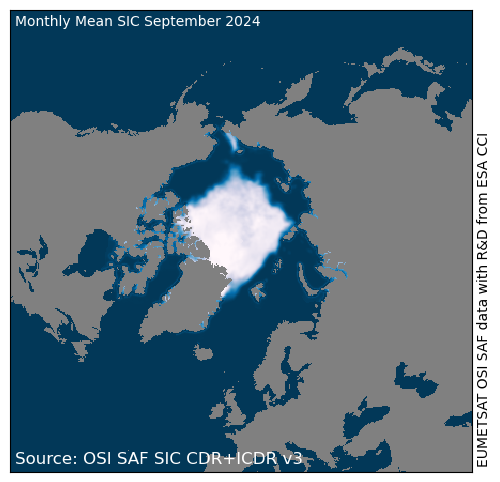

In [190]:
from matplotlib import pylab as plt
from cmocean import cm

cmap = copy(plt.colormaps['PuBu_r'])
cmap.set_bad('grey')

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(month_ds['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=0, vmax=100, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Monthly Mean SIC {:%B %Y}'.format(dt,), va='top', transform=ax.transAxes, color='white')
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax.transAxes, color='white')
plt.show()

In [221]:
# compute climatological anomaly
month_anomaly = month_ds['ice_conc'].drop_dims('time') - climo_mean['ice_conc_mean'].drop_dims('time')
month_anomaly = month_anomaly['ice_conc'].expand_dims(time=month_ds.dims['time'])
#month_anomaly = month_anomaly.transpose('time', 'yc', 'xc')
#print(month_ds.dims)
#print(climo_mean.dims)
#print(month_anomaly.dims)

AttributeError: 'DataArray' object has no attribute 'drop_dims'

FrozenMappingWarningOnValuesAccess({'xc': 432, 'yc': 432, 'time': 1})


KeyError: "No variable named 'ice_conc'. Variables on the dataset include ['xc', 'yc', 'lat', 'lon', 'Lambert_Azimuthal_Grid']"

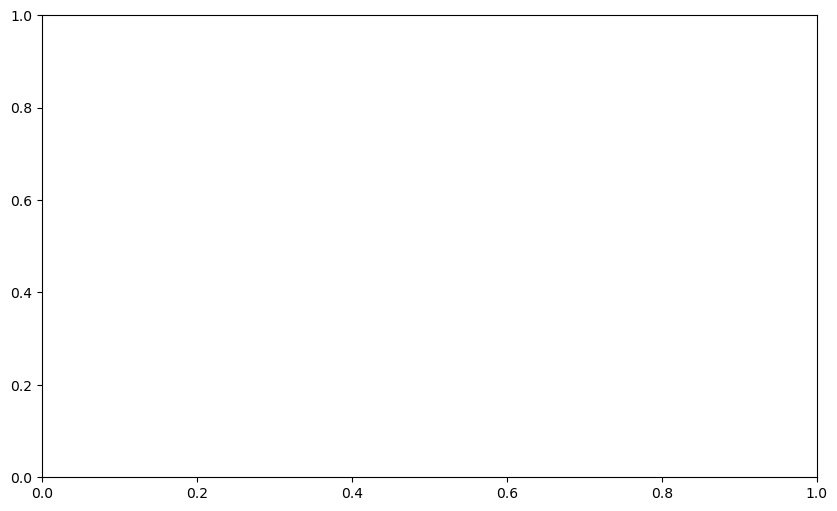

In [220]:
from matplotlib import pylab as plt
from cmocean import cm

cmap = copy(cm.balance_r)
cmap.set_bad('grey')

print(month_anomaly.dims)

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(month_anomaly['ice_conc'][0,:,:].to_masked_array(),
          interpolation='none', vmin=-100, vmax=+100, cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.01,0.99,'Anomaly {:%B %Y} wrt {}-{}'.format(dt, *climo), va='top', transform=ax.transAxes)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI', rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12, va='bottom', transform=ax.transAxes)
plt.show()

### Plot the monthly mean SIC and the outline of the climatology median

/home/thomasl/Downloads/test.tiff


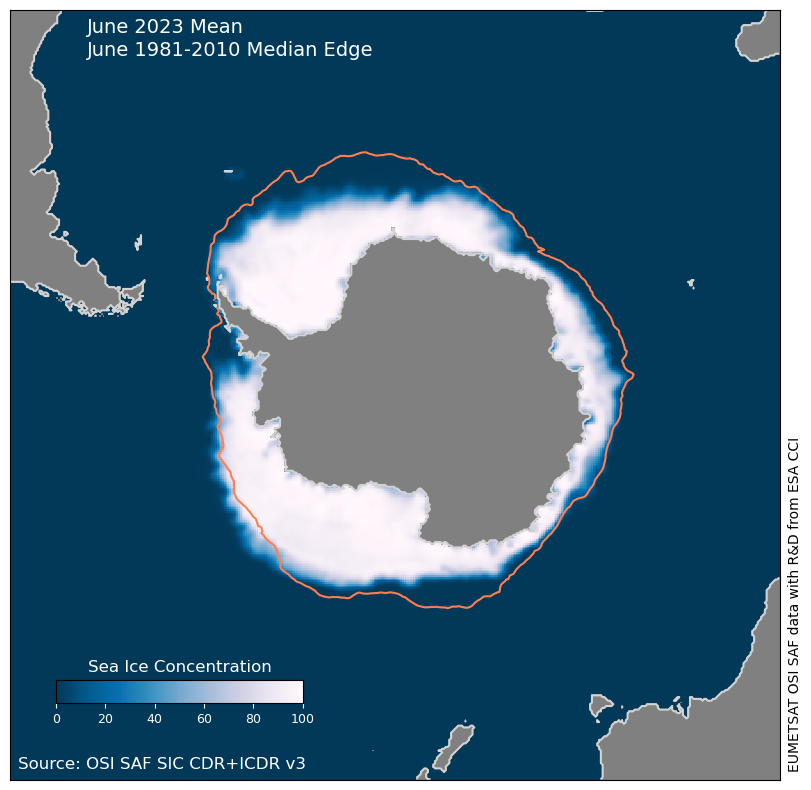

In [16]:
import numpy as np
from matplotlib import pylab as plt
from cmocean import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = copy(cm.ice)
cmap = copy(plt.colormaps['PuBu_r'])
#cmap = copy(plt.colormaps['Blues_r'])
cmap.set_bad('grey')

with_median = True

fig, ax = plt.subplots(figsize=(10,10))
cols = ax.imshow(month_ds['ice_conc'][0].to_masked_array(),
          interpolation='none', vmin=0, vmax=100, cmap=cmap)
ax.contour(np.nan_to_num(month_ds['ice_conc'][0].values,nan=-10), levels=(-10.,),
           colors='lightgrey', linestyles='-')
if with_median:
    ax.contour(climo_med['ice_conc'], levels=(15.,), colors='coral',)

cbaxes = inset_axes(ax, width="32%", height="3%", loc=3, borderpad=0,
                    bbox_to_anchor=(0.06, 0.1, 1, 1),
                    bbox_transform=ax.transAxes)
cbar = plt.colorbar(cols, cax=cbaxes, orientation="horizontal",)
cbar.ax.set_title('Sea Ice Concentration',fontsize=12,color='w')
cbar.ax.tick_params(labelsize=9,colors='w')

ax.set_xticks([])
ax.set_yticks([])
ax.text(0.1,0.99,'{d:%B %Y} Mean'.format(d=dt),
        va='top', transform=ax.transAxes, color='w', fontsize=14,)
if with_median:
    ax.text(0.1,0.96,'{d:%B} {c1:}-{c2:} Median Edge'.format(d=dt, c1=climo[0], c2=climo[1]),
        va='top', transform=ax.transAxes, color='w', fontsize=14,)
ax.text(1.01,0.01,'EUMETSAT OSI SAF data with R&D from ESA CCI',
        rotation=90, ha='left', va='bottom', transform=ax.transAxes)
ax.text(0.01,0.01,'Source: OSI SAF SIC CDR+ICDR v3', fontsize=12,
        va='bottom', transform=ax.transAxes, color='w',)

outname = '/home/thomasl/Downloads/test.tiff'
plt.savefig(outname, bbox_inches='tight')
print(outname)

plt.show()